In [1]:
import cv2
import time
import pygame
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

pygame 2.6.0 (SDL 2.28.4, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Initialize the mediapipe hands class.
mp_hands = mp.solutions.hands

# Set up the Hands functions for images and videos.
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)
hands_videos = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

# Initialize the mediapipe drawing class.
mp_drawing = mp.solutions.drawing_utils

In [3]:
def detectHandsLandmarks(image, hands, draw=True, display = True):
    '''
    This function performs hands landmarks detection on an image.
    Args:
        image:   The input image with prominent hand(s) whose landmarks needs to be detected.
        hands:   The Hands function required to perform the hands landmarks detection.
        draw:    A boolean value that is if set to true the function draws hands landmarks on the output image.
        display: A boolean value that is if set to true the function displays the original input image, and the output
                 image with hands landmarks drawn if it was specified and returns nothing.
    Returns:
        output_image: A copy of input image with the detected hands landmarks drawn if it was specified.
        results:      The output of the hands landmarks detection on the input image.
    '''

    # Create a copy of the input image to draw landmarks on.
    output_image = image.copy()

    # Convert the image from BGR into RGB format.
    imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform the Hands Landmarks Detection.
    results = hands.process(imgRGB)

    # Check if landmarks are found and are specified to be drawn.
    if results.multi_hand_landmarks and draw:

        # Iterate over the found hands.
        for hand_landmarks in results.multi_hand_landmarks:

            # Draw the hand landmarks on the copy of the input image.
            mp_drawing.draw_landmarks(image = output_image, landmark_list = hand_landmarks,
                                      connections = mp_hands.HAND_CONNECTIONS,
                                      landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255),
                                                                                   thickness=2, circle_radius=2),
                                      connection_drawing_spec=mp_drawing.DrawingSpec(color=(0,255,0),
                                                                                     thickness=2, circle_radius=2))

    # Check if the original input image and the output image are specified to be displayed.
    if display:

        # Display the original input image and the output image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output");plt.axis('off');

    # Otherwise
    else:

        # Return the output image and results of hands landmarks detection.
        return output_image, results

c:\Users\dridi\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


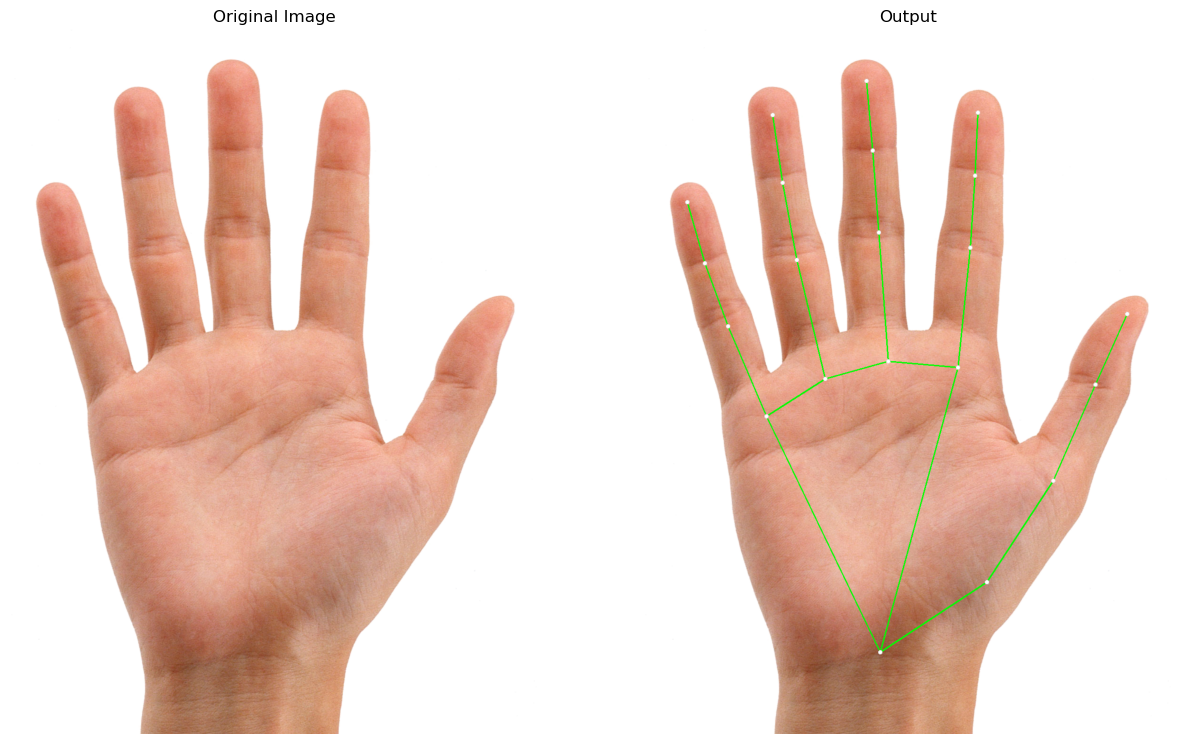

In [4]:
# Read a sample image and perform hands landmarks detection on it.
image = cv2.imread('hand.png')
detectHandsLandmarks(image, hands, display=True)

In [5]:
def countFingers(image, results, draw=True, display=True):
    '''
    This function will count the number of fingers up for each hand in the image.
    Args:
        image:   The image of the hands on which the fingers counting is required to be performed.
        results: The output of the hands landmarks detection performed on the image of the hands.
        draw:    A boolean value that is if set to true the function writes the total count of fingers of the hands on the
                 output image.
        display: A boolean value that is if set to true the function displays the resultant image and returns nothing.
    Returns:
        output_image:     A copy of the input image with the fingers count written, if it was specified.
        fingers_statuses: A dictionary containing the status (i.e., open or close) of each finger of both hands.
        count:            A dictionary containing the count of the fingers that are up, of both hands.
    '''
    
    # Get the height and width of the input image.
    height, width, _ = image.shape
    
    # Create a copy of the input image to write the count of fingers on.
    output_image = image.copy()
    
    # Initialize a dictionary to store the count of fingers of both hands.
    count = {'RIGHT': 0, 'LEFT': 0}
    
    # Store the indexes of the tips landmarks of each finger of a hand in a list.
    fingers_tips_ids = [mp_hands.HandLandmark.INDEX_FINGER_TIP, mp_hands.HandLandmark.MIDDLE_FINGER_TIP,
                        mp_hands.HandLandmark.RING_FINGER_TIP, mp_hands.HandLandmark.PINKY_TIP]
    
    # Initialize a dictionary to store the status (i.e., True for open and False for close) of each finger of both hands.
    fingers_statuses = {'RIGHT_THUMB': False, 'RIGHT_INDEX': False, 'RIGHT_MIDDLE': False, 'RIGHT_RING': False,
                        'RIGHT_PINKY': False, 'LEFT_THUMB': False, 'LEFT_INDEX': False, 'LEFT_MIDDLE': False,
                        'LEFT_RING': False, 'LEFT_PINKY': False}
    
    
    # Iterate over the found hands in the image.
    for hand_index, hand_info in enumerate(results.multi_handedness):
        
        # Retrieve the label of the found hand.
        hand_label = hand_info.classification[0].label
        
        # Retrieve the landmarks of the found hand.
        hand_landmarks =  results.multi_hand_landmarks[hand_index]
        
        # Iterate over the indexes of the tips landmarks of each finger of the hand.
        for tip_index in fingers_tips_ids:
            
            # Retrieve the label (i.e., index, middle, etc.) of the finger on which we are iterating upon.
            finger_name = tip_index.name.split("_")[0]
            
            # Check if the finger is up by comparing the y-coordinates of the tip and pip landmarks.
            if (hand_landmarks.landmark[tip_index].y < hand_landmarks.landmark[tip_index - 2].y):
                
                # Update the status of the finger in the dictionary to true.
                fingers_statuses[hand_label.upper()+"_"+finger_name] = True
                
                # Increment the count of the fingers up of the hand by 1.
                count[hand_label.upper()] += 1
        
        # Retrieve the y-coordinates of the tip and mcp landmarks of the thumb of the hand.
        thumb_tip_x = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].x
        thumb_mcp_x = hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP - 2].x
        
        # Check if the thumb is up by comparing the hand label and the x-coordinates of the retrieved landmarks.
        if (hand_label=='Right' and (thumb_tip_x < thumb_mcp_x)) or (hand_label=='Left' and (thumb_tip_x > thumb_mcp_x)):
            
            # Update the status of the thumb in the dictionary to true.
            fingers_statuses[hand_label.upper()+"_THUMB"] = True
            
            # Increment the count of the fingers up of the hand by 1.
            count[hand_label.upper()] += 1
     
    # Check if the total count of the fingers of both hands are specified to be written on the output image.
    if draw:

        # Write the total count of the fingers of both hands on the output image.
        cv2.putText(output_image, " Total Fingers: ", (10, 25),cv2.FONT_HERSHEY_COMPLEX, 1, (20,255,155), 2)
        cv2.putText(output_image, str(sum(count.values())), (width//2-150,240), cv2.FONT_HERSHEY_SIMPLEX,
                    8.9, (20,255,155), 10, 10)

    # Check if the output image is specified to be displayed.
    if display:
        
        # Display the output image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    # Otherwise
    else:

        # Return the output image, the status of each finger and the count of the fingers up of both hands.
        return output_image, fingers_statuses, count

In [6]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Fingers Counter', cv2.WINDOW_NORMAL)

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Perform Hands landmarks detection on the frame.
    frame, results = detectHandsLandmarks(frame, hands_videos, display=False)
    
    # Check if the hands landmarks in the frame are detected.
    if results.multi_hand_landmarks:
            
        # Count the number of fingers up of each hand in the frame.
        frame, fingers_statuses, count = countFingers(frame, results, display=False)
                
    # Display the frame.
    cv2.imshow('Fingers Counter', frame)
    
    # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()